In [1]:
import tensorflow as tf
from pymousegan.models.lstm import BidirectionalLSTMDiscriminator

seq_shape = (100, 3)
noise_size = (100, 100)

discrim = BidirectionalLSTMDiscriminator(seq_shape, hidden_units_list=[256, 128],
                                         minibatch_discrim_units=10, minibatch_discrim_row_size=3)

discrim.model.summary()

Creating a discrminator with 2 LSTM layers.
Model: "bidirectional_lstm_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 3)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 512)          532480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               656384    
_________________________________________________________________
minibatch_discrimination (Mi (None, 266)               7680      
_________________________________________________________________
dense (Dense)                (None, 1)                 267       
Total params: 1,196,811
Trainable params: 1,196,811
Non-trainable params: 0
_________________________________________________________________


In [2]:
model_path = "/home/joseph/Coding/work/ai_mouse_movements/js/src/discrim_model/discrim_15001_weights.h5"
discrim.model.load_weights(model_path)

In [3]:
discrim.model.summary()

Model: "bidirectional_lstm_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 3)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 512)          532480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               656384    
_________________________________________________________________
minibatch_discrimination (Mi (None, 266)               7680      
_________________________________________________________________
dense (Dense)                (None, 1)                 267       
Total params: 1,196,811
Trainable params: 1,196,811
Non-trainable params: 0
_________________________________________________________________


# Mass Testing Discriminator Performance on Generator
- Is it just predicting "Fake" for everything?

In [18]:
import numpy as np
real_data_path = '/home/joseph/Desktop/DL/ai_mouse_movements/preprocessed_1250_elapsed_thresh.npy'
real_data = np.load(real_data_path)
real_data.shape

(20141, 100, 3)

In [23]:
from tqdm import tqdm
stats = []
for coord in tqdm(real_data[:2048]):
    out = discrim.model.predict(coord[None])
    stats.append(out)

100%|██████████| 2048/2048 [02:26<00:00, 13.95it/s]


In [28]:
stats = [float(out) for out in stats]
stats[0]

0.9413480758666992

(array([  12.,    5.,   14.,  291., 1128.,  395.,  132.,   43.,   22.,
           6.]),
 array([0.9241724 , 0.92830185, 0.9324313 , 0.93656076, 0.94069021,
        0.94481966, 0.94894911, 0.95307856, 0.95720801, 0.96133747,
        0.96546692]),
 <BarContainer object of 10 artists>)

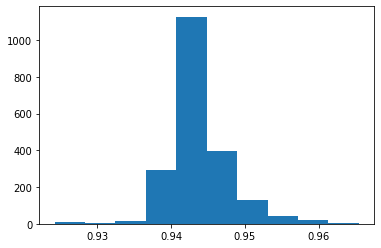

In [29]:
import matplotlib.pyplot as plt
plt.hist(stats)

In [ ]:
# Discriminator overfitted to predict "Real for everything..?"
# Need to try more fake paths

## Testing Good Path but Bad Acceleration

In [30]:
import json
with open("/home/joseph/Coding/work/ai_mouse_movements/js/src/discrim_model/test.json", "rb") as f:
    test_data = json.load(f)
test_data.keys()

dict_keys(['coords'])

In [39]:
# Overfitting?
from tqdm import tqdm
stats = []
for coord in tqdm(real_data[:2048]):
    new_coords = [[xyt[0], xyt[1], 1] for xyt in coord]
    new_coords = np.asarray(new_coords)
    out = discrim.model.predict(new_coords[None])
    stats.append(float(out))
stats[:5]

100%|██████████| 2048/2048 [02:28<00:00, 13.81it/s]


[0.9652359485626221,
 0.9655004143714905,
 0.9657687544822693,
 0.9647606611251831,
 0.9649791717529297]

(array([   3.,    6.,    6.,   14.,   31.,   85.,  253., 1037.,  573.,
          40.]),
 array([0.96414679, 0.96432559, 0.9645044 , 0.9646832 , 0.964862  ,
        0.9650408 , 0.9652196 , 0.96539841, 0.96557721, 0.96575601,
        0.96593481]),
 <BarContainer object of 10 artists>)

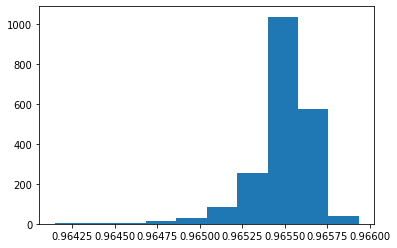

In [40]:
import matplotlib.pyplot as plt
plt.hist(stats)

# Testing with Generator Paths

In [47]:
# With genned paths?
from pymousegan.models.lstm import BidirectionalLSTMDecoderGenerator
def load_gen():
    seq_shape = (100, 3)
    noise_size = (100, 100)
    generator = BidirectionalLSTMDecoderGenerator(noise_size, seq_shape,
                                              hidden_units_list=[256, 128],
                                              output_act='tanh')
    model_path = "/home/joseph/Coding/work/ai_mouse_movements/js/src/model/gen_15001_weights.h5"
    generator.model.load_weights(model_path)
    return generator

def generate_gen_batch(generator, batch_size=16):
    noise = generator.generate_noise(batch_size=batch_size)
    # Generate a batch of new note sequences
    gen_seqs = generator.model.predict(noise)
    return gen_seqs

In [50]:
gen = load_gen()
gen_data = []
batch_size = 16
for i in range(int(2048/batch_size)):
    gen_data.append(generate_gen_batch(gen, batch_size))
len(gen_data)

Creating a generator with 2 LSTM layers.


128

In [54]:
from tqdm import tqdm
stats = []
for coord_batch in tqdm(gen_data):
    out = discrim.model.predict(coord_batch)
    for p in out:
        stats.append(float(p))
stats[:5]

100%|██████████| 128/128 [00:15<00:00,  8.36it/s]


[0.001624464988708496,
 0.0008282363414764404,
 0.002858787775039673,
 0.00043720006942749023,
 0.0009509623050689697]

(array([1895.,   90.,   30.,   18.,    3.,    5.,    2.,    0.,    3.,
           2.]),
 array([2.91305605e-05, 4.00249104e-03, 7.97585152e-03, 1.19492120e-02,
        1.59225725e-02, 1.98959330e-02, 2.38692934e-02, 2.78426539e-02,
        3.18160144e-02, 3.57893749e-02, 3.97627354e-02]),
 <BarContainer object of 10 artists>)

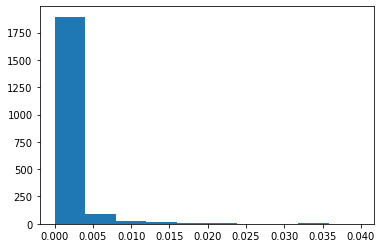

In [55]:
import matplotlib.pyplot as plt
plt.hist(stats)

In [ ]:
# Really good at detecting fake paths LMAOO (closer to 0 --> The more the discriminator thinks the genned data is fake)

In [ ]:
# Possible that the discriminator has just overfitted on the "real data" and 
# no longer considers anything else as "real"